In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import math
import sys
import matplotlib.pyplot as plt

sys.path.append(os.path.join('..','..'))
import EnergyPricesLibrary as Ep
import CustomMetrics

from kerastuner.tuners import BayesianOptimization
from sklearn.metrics import mean_squared_error

%load_ext autoreload
%autoreload 2

In [2]:
def build_model_concat(hourly_input_shape,daily_input_shape,n_steps_out=24):
    
    input_1 = tf.keras.layers.Input(shape=hourly_input_shape)
    input_2 = tf.keras.layers.Input(shape=daily_input_shape)

    model_1_1 = tf.keras.layers.GRU(units=448,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0.06),dropout=0.36,return_sequences=True)(input_1)
    model_1_1 = tf.keras.layers.GRU(units=128,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0.09),dropout=0.36,return_sequences=False)(model_1_1)
    model_1_1 = tf.keras.layers.Dense(units=n_steps_out,activation='relu')(model_1_1)

    model_2_2 = tf.keras.layers.GRU(units=256,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0),dropout=0,return_sequences=True)(input_2)
    model_2_2 = tf.keras.layers.GRU(units=512,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0),dropout=0,return_sequences=True)(model_2_2)
    model_2_2 = tf.keras.layers.Flatten()(model_2_2)
    model_2_2 = tf.keras.layers.Dense(units=n_steps_out,activation='relu')(model_2_2)

    output = tf.keras.layers.Concatenate()([model_1_1, model_2_2])
    output = tf.keras.layers.Dense(units=96,activation='relu')(output)
    output = tf.keras.layers.Dense(units=96,activation='relu')(output)
    
    output = tf.keras.layers.Dense(units=n_steps_out,activation=None)(output)

    full_model = tf.keras.Model(inputs=[input_1, input_2], outputs=[output])
    
    return full_model

def build_model_sum(hourly_input_shape,daily_input_shape,n_steps_out=24):
    
    input_1 = tf.keras.layers.Input(shape=hourly_input_shape)
    input_2 = tf.keras.layers.Input(shape=daily_input_shape)

    model_1_1 = tf.keras.layers.GRU(units=448,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0.06),dropout=0.36,return_sequences=True)(input_1)
    model_1_1 = tf.keras.layers.GRU(units=128,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0.09),dropout=0.36,return_sequences=False)(model_1_1)
    model_1_1 = tf.keras.layers.Dense(units=n_steps_out,activation='relu')(model_1_1)

    model_2_2 = tf.keras.layers.GRU(units=256,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0),dropout=0,return_sequences=True)(input_2)
    model_2_2 = tf.keras.layers.GRU(units=512,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0),dropout=0,return_sequences=True)(model_2_2)
    model_2_2 = tf.keras.layers.Flatten()(model_2_2)
    model_2_2 = tf.keras.layers.Dense(units=n_steps_out,activation='relu')(model_2_2)

    output = tf.keras.layers.Add()([model_1_1, model_2_2])
    
    output = tf.keras.layers.Dense(units=n_steps_out,activation=None)(output)

    full_model = tf.keras.Model(inputs=[input_1, input_2], outputs=[output])
    
    return full_model

def make_predictions(model,scaler_D_x,scaler_D_y,scaler_H_x,scaler_H_y,
                     trainX_D, trainY_D, testX_D, testY_D,
                     trainX_H, trainY_H, testX_H, testY_H,
                     n_steps_out,len_output_features):
    
    # make predictions
    trainPredict = model.predict([trainX_H,trainX_D])
    trainPredict = trainPredict.reshape(trainPredict.shape[0]*n_steps_out,len_output_features)
    testPredict  = model.predict([testX_H,testX_D])
    testPredict  = testPredict.reshape(testPredict.shape[0]*n_steps_out,len_output_features)
    
    # invert predictions
    trainPredict = scaler_D_y.inverse_transform(trainPredict)
    trainY = scaler_D_y.inverse_transform(trainY_D.reshape(trainY_D.shape[0]*n_steps_out,len_output_features))
    
    testPredict = scaler_D_y.inverse_transform(testPredict)
    testY = scaler_D_y.inverse_transform(testY_D.reshape(testY_D.shape[0]*n_steps_out,len_output_features))
        
    return trainPredict,trainY,testPredict,testY

def get_metrics(trainY,trainPredict,testY,testPredict):
    
    trainMAPE  = Ep.MAPE(trainPredict,trainY)
    testMAPE  = Ep.MAPE(testPredict,testY)
    
    train_sMAPE  = Ep.sMAPE(trainY,trainPredict)
    test_sMAPE  = Ep.sMAPE(testY,testPredict)
    
    return trainMAPE,testMAPE,train_sMAPE,test_sMAPE

In [3]:
data_diaria_path = os.path.join('..','..','..','..','dataset','Series','Sabanas','Original','Sabana_Datos_Diaria.xlsx')
data_diaria = pd.read_excel(data_diaria_path)
data_diaria = data_diaria.set_index('Fecha')

In [4]:
data_horaria_path = os.path.join('..','..','..','..','dataset','Series','Sabanas','Original','Sabana_Datos_Horaria.xlsx')
data_horaria = pd.read_excel(data_horaria_path)
data_horaria = data_horaria.set_index('Fecha')

In [5]:
precio_bolsa_path = os.path.join('..','..','..','..','dataset','Series','Sabanas','Original','Sabana_Datos_Precio_Bolsa.xlsx')
precio_bolsa = pd.read_excel(precio_bolsa_path)
precio_bolsa = precio_bolsa.set_index('Fecha')

In [6]:
nombre_series_diaria = data_diaria.columns.values
nombre_series_horaria = data_horaria.columns.values

In [7]:
data_horaria_full = pd.concat([data_horaria,precio_bolsa],axis=1)
nombre_series_horaria = data_horaria_full.columns.values

In [8]:
data_horaria.shape,data_diaria.shape, precio_bolsa.shape

((177480, 85), (7395, 119), (177480, 1))

## Build Window

In [9]:
d = 'All'
start_date_train = '2000-02-01'
start_date_val = '2020-01-01'
start_date_test = '2020-04-01'
end_date_test = '2020-05-01'
n_steps_out=24
output_columns = ['$kWh']

In [10]:
n_steps_in = 5
overlap = 1
inputs_columns = nombre_series_diaria

len_input_features = len(inputs_columns)
len_output_features = len(output_columns)

results = Ep.SplitTimeseriesMultipleTimesBackAhead_differentTimes(df_x=data_diaria,
                                                                  df_y=precio_bolsa,
                                                                  day=d,
                                                                  start_date_train=start_date_train,start_date_val=start_date_val,
                                                                  start_date_test=start_date_test,end_date_test=end_date_test,
                                                                  n_steps_out=n_steps_out,n_steps_in=n_steps_in,
                                                                  overlap=overlap,input_features=inputs_columns,
                                                                  output_features=output_columns)

trainX_D,trainY_D,valX_D,valY_D,testX_D,testY_D,scaler_D_x,scaler_D_y,dataset_x_D, dataset_y_D = results

In [11]:
n_steps_in = 120
overlap = 24
inputs_columns = nombre_series_horaria

len_input_features = len(inputs_columns)
len_output_features = len(output_columns)

results = Ep.SplitTimeseriesMultipleTimesBackAhead(df=data_horaria_full,
                                                   day=d,
                                                   start_date_train=start_date_train,start_date_val=start_date_val,
                                                   start_date_test=start_date_test,end_date_test=end_date_test,
                                                   n_steps_out=n_steps_out,n_steps_in=n_steps_in,overlap=overlap,
                                                   input_features=inputs_columns,output_features=output_columns)

trainX_H,trainY_H,valX_H,valY_H,testX_H,testY_H,scaler_H_x,scaler_H_y,dataset_x_H, dataset_y_H = results

### Train

In [12]:
'Diaria:',trainX_D.shape,trainY_D.shape,'Horaria:',trainX_H.shape, trainY_H.shape

('Diaria:',
 (7269, 5, 119),
 (7269, 24, 1),
 'Horaria:',
 (7269, 120, 86),
 (7269, 24, 1))

In [13]:
'Diaria:',valX_D.shape,valY_D.shape,'Horaria:',valX_H.shape,valY_H.shape

('Diaria:', (91, 5, 119), (91, 24, 1), 'Horaria:', (91, 120, 86), (91, 24, 1))

In [14]:
trainX_D = np.concatenate([trainX_D,valX_D])
trainY_D = np.concatenate([trainY_D,valY_D])

trainX_H = np.concatenate([trainX_H,valX_H])
trainY_H = np.concatenate([trainY_H,valY_H])

In [15]:
'Diaria:',trainX_D.shape, trainY_D.shape,'Horaria:',trainX_H.shape, trainY_H.shape

('Diaria:',
 (7360, 5, 119),
 (7360, 24, 1),
 'Horaria:',
 (7360, 120, 86),
 (7360, 24, 1))

### Test

In [16]:
'Diaria:',testX_D.shape, testY_D.shape,'Horaria:',testX_H.shape, testY_H.shape,'Imagenes:'

('Diaria:',
 (30, 5, 119),
 (30, 24, 1),
 'Horaria:',
 (30, 120, 86),
 (30, 24, 1),
 'Imagenes:')

## Model

In [17]:
log_dir = os.path.join('logs','ModeloCompleto_I5_Sum-DenseRelu-kWh')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
callback_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                          histogram_freq=2,
                                                          write_graph=True,
                                                          update_freq='epoch')

callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                          factor=0.1,
                                                          min_lr=1e-5,
                                                          patience=5,
                                                          verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min')

callbacks = [callback_reduce_lr,early_stopping,callback_tensorboard]

In [18]:
hourly_input_shape = (trainX_H.shape[1],trainX_H.shape[2])
daily_input_shape = (trainX_D.shape[1],trainX_D.shape[2])

model = build_model_sum(hourly_input_shape,daily_input_shape)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5, 119)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 120, 86)]    0                                            
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 5, 256)       289536      input_2[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       (None, 120, 448)     720384      input_1[0][0]                    
_______________________________________________________________________________________

In [19]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00035860735981893),
              loss=CustomMetrics.symmetric_mean_absolute_percentage_error,
              metrics=[tf.metrics.MeanAbsoluteError(),
                       tf.keras.metrics.MeanAbsolutePercentageError(),
                       CustomMetrics.symmetric_mean_absolute_percentage_error])

In [20]:
"""
import json

model_json = model.to_json()
with open("ModeloCompleto_I15_Sum-2.json", "w") as json_file:
    json_file.write(model_json)
"""

'\nimport json\n\nmodel_json = model.to_json()\nwith open("ModeloCompleto_I15_Sum-2.json", "w") as json_file:\n    json_file.write(model_json)\n'

In [21]:
model.fit([trainX_H,trainX_D], trainY_D, validation_data=([testX_H,testX_D],testY_D),
               epochs=110,callbacks=callbacks,verbose=1)

Epoch 1/110
  1/230 [..............................] - ETA: 0s - loss: 4478.4297 - mean_absolute_error: 0.0952 - mean_absolute_percentage_error: 542.1787 - symmetric_mean_absolute_percentage_error: 3595.9331WARNING:tensorflow:From C:\Users\SEBASTIAN\anaconda3\envs\proyecto-grados\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
230/230 [==============================] - 11s 49ms/step - loss: 2186.4727 - mean_absolute_error: 0.0272 - mean_absolute_percentage_error: 3022.8696 - symmetric_mean_absolute_percentage_error: 1482.8489 - val_loss: 1346.9788 - val_mean_absolute_error: 0.0256 - val_mean_absolute_percentage_error: 31.3702 - val_symmetric_mean_absolute_percentage_error: 805.7682
Epoch 2/110
230/230 [==============================] - 9s 40ms/step - loss: 1324.7660 - mean_absolute_error: 0.0146 - mean_a

Epoch 21/110
230/230 [==============================] - 9s 41ms/step - loss: 636.7916 - mean_absolute_error: 0.0099 - mean_absolute_percentage_error: 1110.0369 - symmetric_mean_absolute_percentage_error: 631.0725 - val_loss: 441.4812 - val_mean_absolute_error: 0.0157 - val_mean_absolute_percentage_error: 20.4232 - val_symmetric_mean_absolute_percentage_error: 437.9155
Epoch 22/110
230/230 [==============================] - 9s 40ms/step - loss: 635.9048 - mean_absolute_error: 0.0099 - mean_absolute_percentage_error: 1194.6443 - symmetric_mean_absolute_percentage_error: 633.0579 - val_loss: 382.5298 - val_mean_absolute_error: 0.0127 - val_mean_absolute_percentage_error: 15.6601 - val_symmetric_mean_absolute_percentage_error: 380.2141
Epoch 23/110
230/230 [==============================] - 9s 41ms/step - loss: 626.6559 - mean_absolute_error: 0.0097 - mean_absolute_percentage_error: 1019.9238 - symmetric_mean_absolute_percentage_error: 624.6916 - val_loss: 538.4584 - val_mean_absolute_erro

### Validación

In [22]:
model.evaluate(x=[testX_H,testX_D], y=testY_D)

1/1 [==============================] - 0s 2ms/step - loss: 404.4367 - mean_absolute_error: 0.0134 - mean_absolute_percentage_error: 15.9284 - symmetric_mean_absolute_percentage_error: 404.2683


[404.43670654296875,
 0.013380604796111584,
 15.928362846374512,
 404.2682800292969]

In [23]:
trainPredict,trainY,testPredict,testY = make_predictions(model,scaler_D_x,scaler_D_y,scaler_H_x,scaler_H_y,
                                                         trainX_D, trainY_D, testX_D, testY_D,
                                                         trainX_H, trainY_H, testX_H, testY_H,
                                                         n_steps_out,len_output_features)

In [24]:
trainPredict.shape,trainY.shape,testPredict.shape,testY.shape

((176640, 1), (176640, 1), (720, 1), (720, 1))

In [25]:
trainMAPE,testMAPE,train_sMAPE,test_sMAPE = get_metrics(trainY,trainPredict,testY,testPredict)

In [26]:
trainMAPE,testMAPE,train_sMAPE,test_sMAPE

(0.16729327420357018,
 0.14508794873451308,
 15.594972097823062,
 15.294870177414182)

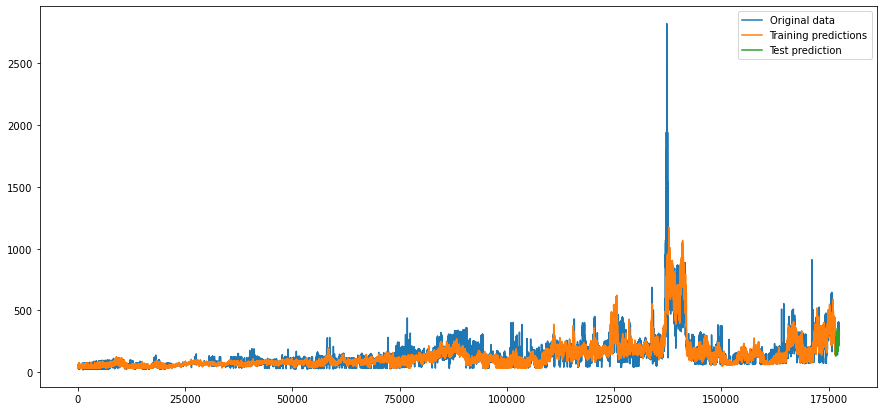

In [27]:
Nt = trainPredict.shape[0] + testPredict.shape[0]
trainPredictPlot = np.zeros((Nt,1))
trainPredictPlot[:,:] = np.nan
trainPredictPlot[:len(trainPredict), :] = np.concatenate((dataset_y_D[0].reshape(1,1),trainPredict[:-1]))

# shift test predictions for plotting
testPredictPlot = np.zeros((Nt,1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):Nt, :] = testPredict

plt.figure(figsize=(15,7))
plt.plot(np.concatenate((trainY,testY)),label='Original data')
plt.plot(trainPredictPlot,label='Training predictions')
plt.plot(testPredictPlot,label='Test prediction')
plt.legend()
plt.show()

In [28]:
"""
# shift test predictions for plotting
testOriginalPlot = np.zeros((Nt,1))
testOriginalPlot[:, :] = np.nan
testOriginalPlot[len(trainPredict):Nt, :] = testY

# shift test predictions for plotting
testPredictPlot = np.zeros((Nt,1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):Nt, :] = testPredict

plt.figure(figsize=(15,7))
plt.plot(testOriginalPlot,label='Original data')
plt.plot(testPredictPlot,label='Test prediction')
plt.legend()
plt.show()
"""

"\n# shift test predictions for plotting\ntestOriginalPlot = np.zeros((Nt,1))\ntestOriginalPlot[:, :] = np.nan\ntestOriginalPlot[len(trainPredict):Nt, :] = testY\n\n# shift test predictions for plotting\ntestPredictPlot = np.zeros((Nt,1))\ntestPredictPlot[:, :] = np.nan\ntestPredictPlot[len(trainPredict):Nt, :] = testPredict\n\nplt.figure(figsize=(15,7))\nplt.plot(testOriginalPlot,label='Original data')\nplt.plot(testPredictPlot,label='Test prediction')\nplt.legend()\nplt.show()\n"

In [29]:
testOriginalPlot = np.zeros((testY.shape[0],1))
testOriginalPlot[:, :] = testY

testPredictPlot = np.zeros((testPredict.shape[0],1))
testPredictPlot[:, :] = testPredict

In [30]:
test_size = testY.shape[0]
precio_bolsa_test = precio_bolsa[-test_size:]
precio_bolsa_test = precio_bolsa_test.copy()
precio_bolsa_test['day_of_week']  = precio_bolsa_test.index.day_name()
precio_bolsa_test['date']  = precio_bolsa_test.index.date
precio_bolsa_test['idx'] = np.arange(len(precio_bolsa_test))

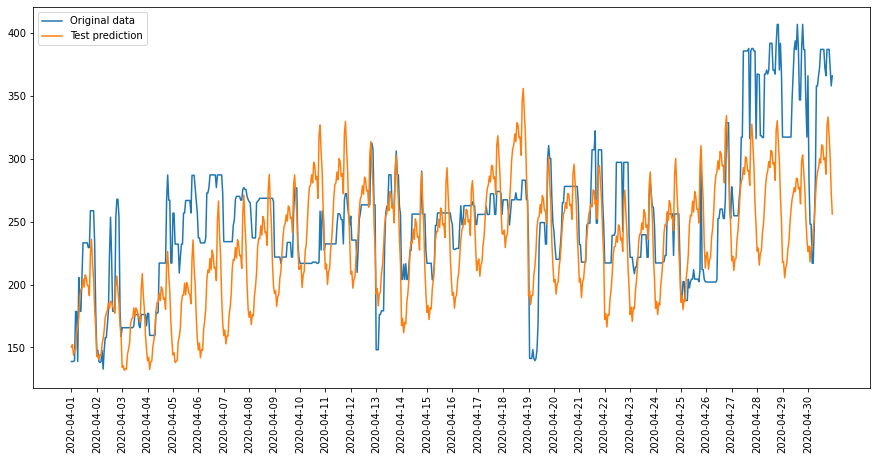

In [31]:
lista_fechas = pd.unique(precio_bolsa_test['date'])

plt.figure(figsize=(15,7))
plt.plot(testOriginalPlot,label='Original data')
plt.plot(testPredictPlot,label='Test prediction')
plt.xticks(ticks=np.arange(0, 720, step=24),labels=lista_fechas,rotation=90)
plt.legend()
plt.show()